# Lexis Date Parser

This script normalizes dates from LexisUni and visualizes attention across outlets over time.

In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.parser import parse
from openpyxl import Workbook, load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows


In [9]:
# Stap 1: Bestanden inlezen en hyperlinks extraheren
directory = "data/"
files = [f for f in os.listdir(directory) if f.endswith(".XLSX")]
all_data = []

for file in files:
    file_path = os.path.join(directory, file)
    try:
        # Laad het Excel-bestand met openpyxl
        wb = load_workbook(file_path, data_only=True)
        sheet = wb.active  # Gebruik het actieve werkblad

        # Lees de data in met pandas
        df = pd.read_excel(file_path, engine='openpyxl')
        
        # Controleer of de 'Title'-kolom bestaat en lees hyperlinks
        if 'Titel' in df.columns:
            # Zoek de kolomindex van 'Title'
            title_col_idx = df.columns.get_loc('Titel') + 1  # Openpyxl gebruikt 1-based index

            # Lees hyperlinks uit de juiste kolom
            hyperlinks = []
            for row in sheet.iter_rows(min_row=2, max_row=sheet.max_row, min_col=title_col_idx, max_col=title_col_idx):
                cell = row[0]
                hyperlink = cell.hyperlink.target if cell.hyperlink else None
                hyperlinks.append(hyperlink)
            
            # Voeg de 'Hyperlink' kolom toe aan de dataframe
            df['Hyperlink'] = hyperlinks
        else:
            # Voeg een lege kolom toe als 'Title' niet bestaat
            df['Hyperlink'] = None
        
        df['Source'] = file  # Voeg de bestandsnaam als bron toe
        all_data.append(df)
        print(f"Loaded {file} with {df.shape[0]} rows and {df.shape[1]} columns")
    
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Combineer alle dataframes
combined_df = pd.concat(all_data, ignore_index=True)


Loaded AD 2022-2023 hele sample.XLSX with 410 rows and 23 columns
Loaded AD 2019-2021 hele sample.XLSX with 462 rows and 23 columns
Loaded Volkskrant 2019-2021 hele sample.XLSX with 353 rows and 23 columns
Loaded Volkskrant 2022-2024 bijna hele sample.XLSX with 0 rows and 23 columns
Loaded Telegraaf 2022-2024 hele sample.XLSX with 396 rows and 23 columns
Loaded NRC 2022-2024 hele sample.XLSX with 487 rows and 23 columns
Loaded AD 2024 hele sample.XLSX with 166 rows and 23 columns
Loaded Volkskrant 2022-2024 201-500.XLSX with 300 rows and 23 columns
Loaded Volkskrant 2022-2024 einde sample laatste 16.XLSX with 16 rows and 23 columns
Loaded Telegraaf 2019-2021 hele sample.XLSX with 217 rows and 23 columns
Loaded NRC 2019-2021 hele sample.XLSX with 366 rows and 23 columns
Loaded Volkskrant 2022-2024 1-200.XLSX with 200 rows and 23 columns


In [10]:
# Function to normalize date format

def normalize_datum(date_str):
   
    month_translation = {
        "januari": "January", "februari": "February", "maart": "March", "april": "April",
        "mei": "May", "juni": "June", "juli": "July", "augustus": "August", "september": "September",
        "oktober": "October", "november": "November", "december": "December"
    }
    
    for dutch, english in month_translation.items():
        date_str = date_str.replace(dutch, english)

    date_str = " ".join(word for word in date_str.split() if not word.isalpha() or word in month_translation.values())
    return parse(date_str, dayfirst=True).date()

combined_df["Datum"] = combined_df["Datum"].apply(normalize_datum)

combined_df["Datum"] = pd.to_datetime(combined_df["Datum"])
print(combined_df["Datum"])

0      2022-01-09
1      2022-01-09
2      2022-01-09
3      2022-01-10
4      2022-01-12
          ...    
3368   2023-01-31
3369   2023-02-01
3370   2023-02-08
3371   2023-02-08
3372   2023-02-09
Name: Datum, Length: 3373, dtype: datetime64[ns]


In [11]:
publication_map = {
    'AD/Algemeen Dagblad.nl': 'Algemeen Dagblad',
    'AD/Algemeen Dagblad': 'Algemeen Dagblad',
    'de Volkskrant': 'Volkskrant',
    'De Volkskrant.nl': 'Volkskrant',
    'De Telegraaf.nl': 'Telegraaf',
    'De Telegraaf': 'Telegraaf',
    'NRC.nl': 'NRC',
    'NRC Handelsblad': 'NRC',
    'NRC': 'NRC'
}

# Normalize the 'Publicatie' column using the mapping
combined_df['Publicatie_unique'] = combined_df['Publicatie'].replace(publication_map)
# Check the unique values after normalization
print(combined_df['Publicatie'].unique())

['AD/Algemeen Dagblad.nl' 'AD/Algemeen Dagblad' 'de Volkskrant'
 'De Volkskrant.nl' 'De Telegraaf.nl' 'De Telegraaf' 'NRC.nl'
 'NRC Handelsblad' 'NRC']


## Visualize

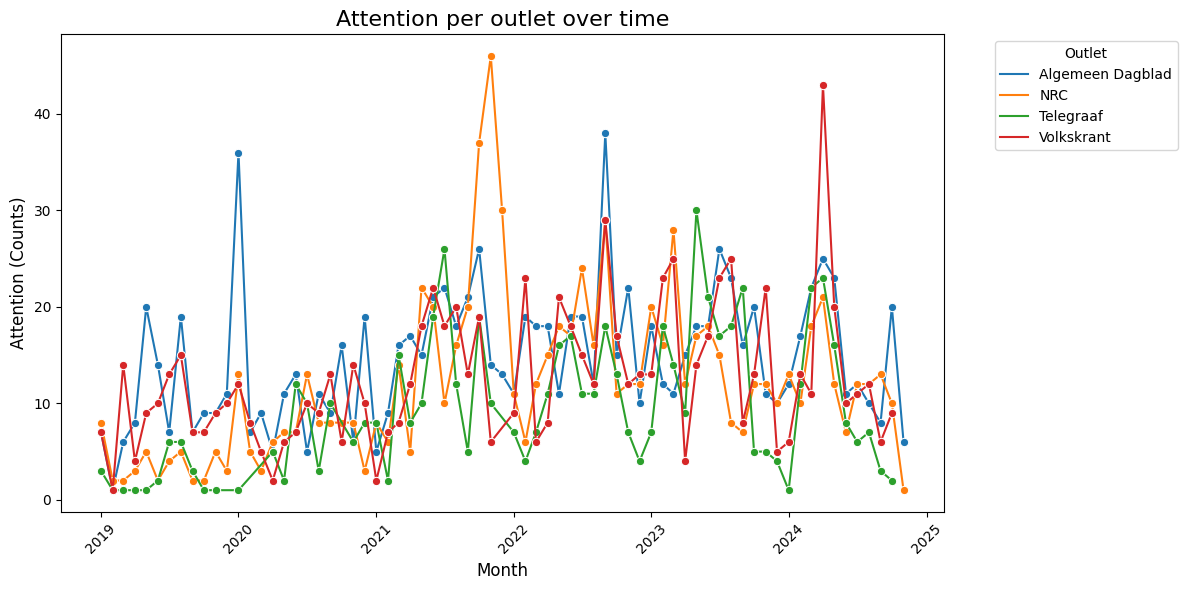

In [13]:

aggregated_df = combined_df.groupby(['Datum', 'Publicatie_unique']).size().reset_index(name='Attention')
aggregated_df['Month'] = aggregated_df['Datum'].dt.to_period('M').dt.to_timestamp()
monthly_df = aggregated_df.groupby(['Month', 'Publicatie_unique'])['Attention'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_df, x='Month', y='Attention', hue='Publicatie_unique', marker='o')

plt.title('Attention per outlet over time', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Attention (Counts)', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Outlet', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

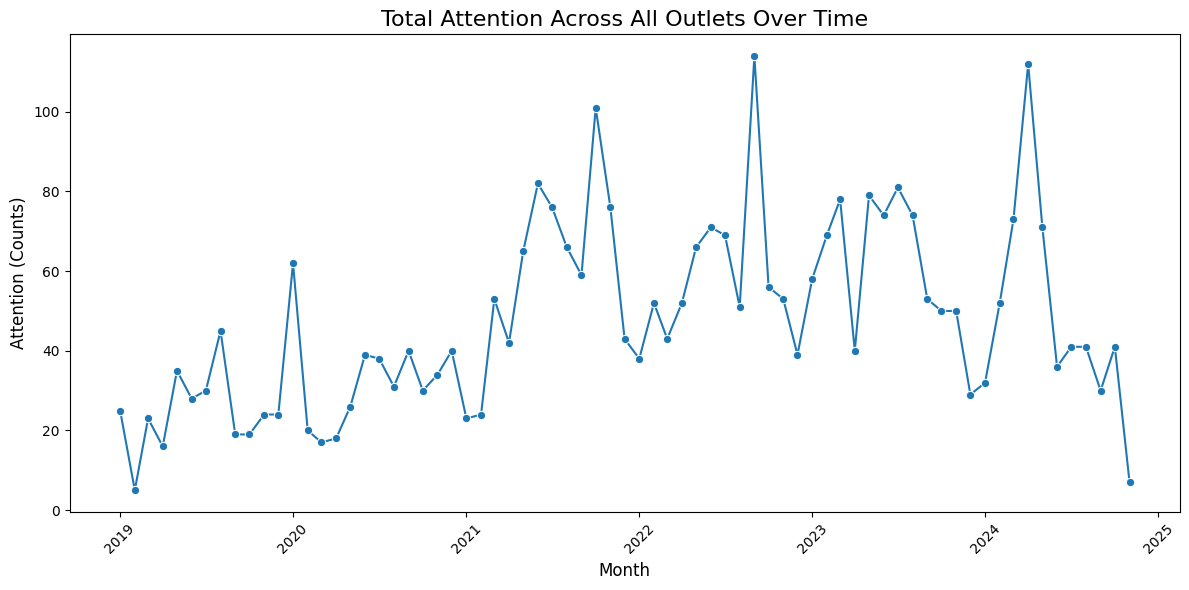

In [14]:
combined_attention_df = aggregated_df.groupby('Month')['Attention'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_attention_df, x='Month', y='Attention', marker='o')

plt.title('Total attention across all outlets over time', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Attention (Counts)', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [15]:
combined_df[["Publicatie", "Datum"]].head()

,Publicatie,Datum
0,AD/Algemeen Dagblad.nl,2022-01-09
1,AD/Algemeen Dagblad.nl,2022-01-09
2,AD/Algemeen Dagblad.nl,2022-01-09
3,AD/Algemeen Dagblad.nl,2022-01-10
4,AD/Algemeen Dagblad.nl,2022-01-12


In [16]:
combined_df.to_csv("data/normalized_data/normalized_dates.csv", index=False, encoding="utf-8")
combined_df.to_excel("data/normalized_data/normalized_dates.xlsx", index=False, engine="openpyxl")

## Suggestion for sampling strategy: Constructed month sampling (tbd)


A constructed month sampling strategy is a way to create a representative selection of news coverage from a given month while making sure every publication is fairly represented. Instead of randomly picking days, this method selects one day per week for each publication, ensuring that the sample isn't skewed toward a specific period within the month. Some outlets publish every day, while others might only have articles on certain days, so this approach adjusts for that by only sampling from weeks where an outlet actually published something.

The process starts by grouping the data by both the OUTLET and the MONTH. Within each group, it identifies the weeks where articles were published. Instead of forcing a selection from every week, it only picks from the ones that actually have coverage. From each available week, it randomly selects one day. This means that if a newspaper only published in three out of four weeks in a month, the sample would reflect that naturally without introducing bias.

This method ensures that the sample is not dominated by certain weeks or missing major timeframes/ by specific outlets.





In [20]:
combined_df["Datum"] = pd.to_datetime(combined_df["Datum"])

combined_df["YearMonth"] = combined_df["Datum"].dt.to_period("M")
combined_df["Week"] = combined_df["Datum"].dt.isocalendar().week  # ISO week number


def sample_constructed_month(df):
    sampled_days = []
    
    # Group by month and outlet
    for (year_month, outlet), group in df.groupby(["YearMonth", "Publicatie"]):
        # Get available weeks
        available_weeks = group["Week"].unique()
        
        # Sample one random day per available week
        weekly_samples = (
            group.groupby("Week", group_keys=False)  # Add group_keys=False here
            .apply(lambda x: x.sample(n=1, random_state=42))  # Sample one day per week
            .reset_index(drop=True)
        )
        sampled_days.append(weekly_samples)
    
    return pd.concat(sampled_days, ignore_index=True)



constructed_month_df = sample_constructed_month(combined_df)

constructed_month_df = constructed_month_df.drop(columns=["YearMonth", "Week"])

print(f"Total sampled items: {constructed_month_df.shape[0]}")

Total sampled items: 1595


# Final sampling strategy: Constructed Year, stratefied by Month/ Outlet

It extracts the year and month (YearMonth) for grouping purposes. Each article is assigned a unique identifier (Article_ID). For each combination of year-month and publication outlet, one random article is sampled.
The result is a dataset where each outlet is represented by a single article per month, ensuring temporal and publication diversity.

In [21]:

# Convert "Datum" to datetime format
combined_df["Datum"] = pd.to_datetime(combined_df["Datum"])

# Extract YearMonth for grouping (e.g., '2023-05' for May 2023)
combined_df["YearMonth"] = combined_df["Datum"].dt.to_period("M")

# Add a unique identifier for each news article
combined_df["Article_ID"] = range(1, len(combined_df) + 1)

def sample_constructed_year(df):
    sampled_days = []

    # Group by YearMonth and unique outlet
    for (year_month, publicatie_unique), group in df.groupby(["YearMonth", "Publicatie_unique"]):
        # Sample one article per month per outlet
        monthly_sample = group.sample(n=1, random_state=42)
        sampled_days.append(monthly_sample)

    return pd.concat(sampled_days, ignore_index=True)

# Apply the function to sample one article per outlet per month
constructed_year_df = sample_constructed_year(combined_df)

# Drop the YearMonth column to keep the output clean
constructed_year_df = constructed_year_df.drop(columns=["YearMonth"])

print(f"Total sampled items: {constructed_year_df.shape[0]}")


Total sampled items: 276


In [22]:
# Save the sampled data to Excel with hyperlinks
output_path = "data/normalized_data/constructed_year.xlsx"
wb = Workbook()
ws = wb.active

# Write headers
ws.append(constructed_year_df.columns.tolist())

# Write data including hyperlinks
for row in dataframe_to_rows(constructed_year_df, index=False, header=False):
    ws.append(row)

# Add hyperlinks if present
if 'Hyperlink' in constructed_year_df.columns:  # Check if 'Hyperlink' exists
    for row_idx, link in enumerate(constructed_year_df['Hyperlink'], start=2):
        if link:
            ws[f"A{row_idx}"].hyperlink = link
            ws[f"A{row_idx}"].style = "Hyperlink"  # Optional: Apply hyperlink style

# Save Excel file
wb.save(output_path)
print(f"Sampled data with hyperlinks saved in {output_path}")

# Save to CSV
csv_output_path = "data/normalized_data/constructed_year.csv"
constructed_year_df.to_csv(csv_output_path, index=False)
print(f"Sampled data with hyperlinks saved in {csv_output_path}")

Sampled data with hyperlinks saved in data/normalized_data/constructed_year.xlsx
Sampled data with hyperlinks saved in data/normalized_data/constructed_year.csv
